In [15]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 193.82it/s]


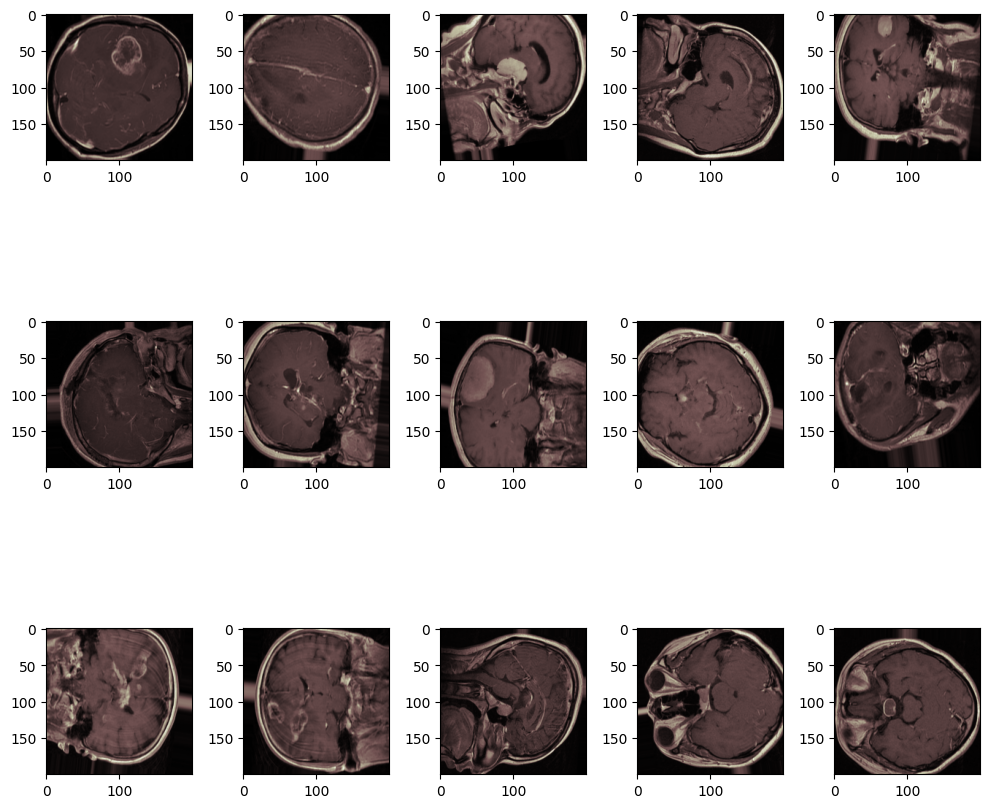

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-09 15:28:20.218266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 15:28:20.528957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-09 15:28:49.016310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 15:28:49.606776: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-09 15:28:49.606828: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-09 15:28:49.607024: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-09 15:28:50.385016: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7543
Epoch 1: saving model to model-DenseNet121.h5
Epoch 1: 29.05 seconds
264/264 [==============================] - 29s 74ms/step - loss: 0.5786 - accuracy: 0.7543 - val_loss: 10.3744 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8786
Epoch 2: saving model to model-DenseNet121.h5
Epoch 2: 16.69 seconds
264/264 [==============================] - 17s 63ms/step - loss: 0.3156 - accuracy: 0.8785 - val_loss: 6.2840 - val_accuracy: 0.4573 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9162
Epoch 3: saving model to model-DenseNet121.h5
Epoch 3: 16.80 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.2220 - accuracy: 0.9163 - val_loss: 2.7221 - val_accuracy: 0.4715 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - l

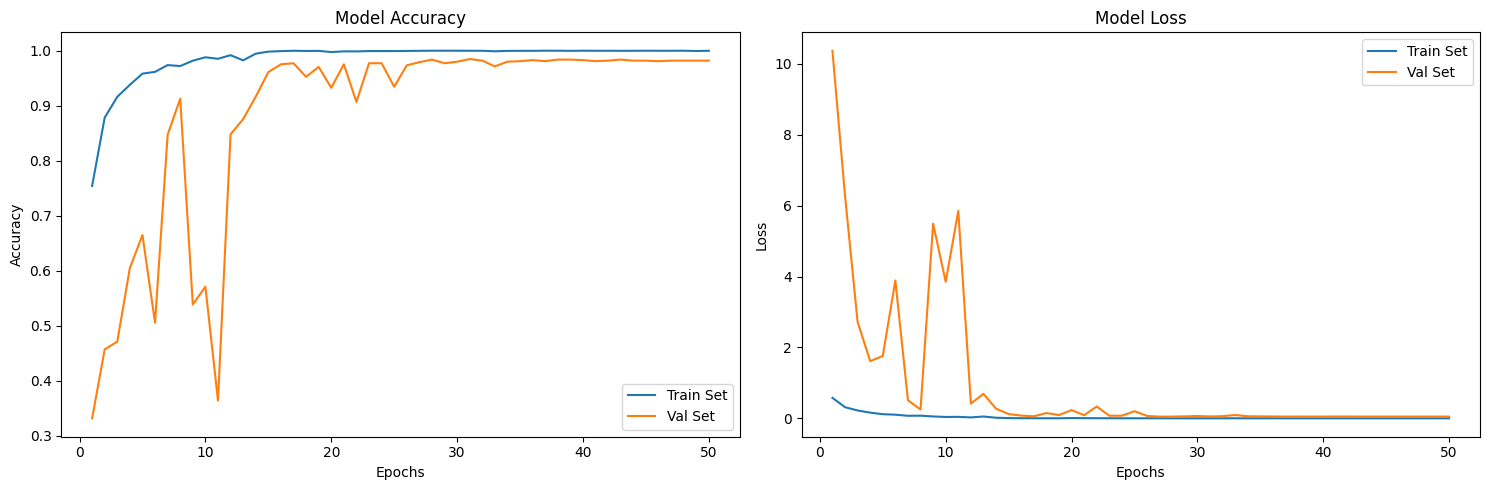

In [5]:
draw_curve(history)

20/20 [==============================] - 0s 19ms/step - loss: 0.0990 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9790    0.9790    0.9790       286
  meningioma     0.9500    0.9366    0.9433       142
   pituitary     0.9734    0.9839    0.9786       186

    accuracy                         0.9707       614
   macro avg     0.9675    0.9665    0.9670       614
weighted avg     0.9706    0.9707    0.9706       614



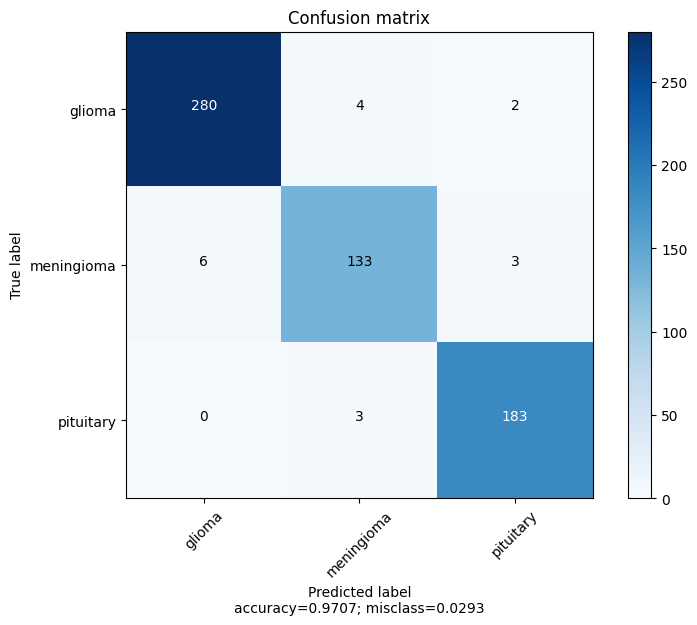

In [6]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [7]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.97it/s]


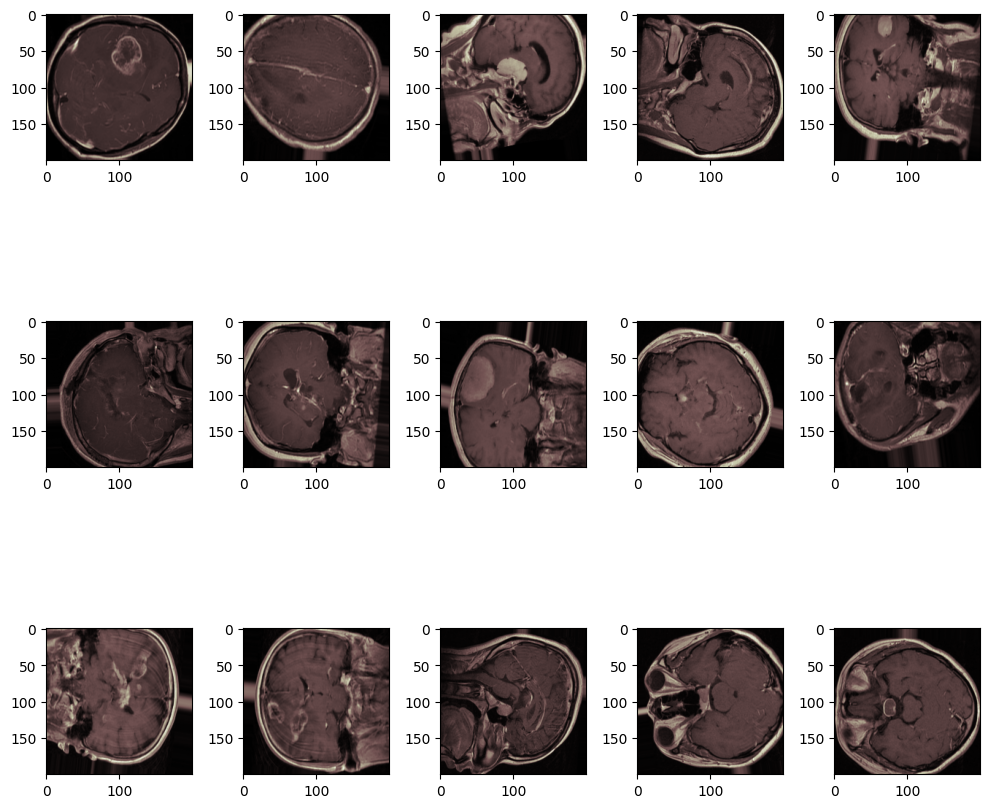

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.7501
Epoch 1: saving model to model-DenseNet121.h5
Epoch 1: 25.23 seconds
264/264 [==============================] - 25s 70ms/step - loss: 0.5952 - accuracy: 0.7498 - val_loss: 8.8035 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8761
Epoch 2: saving model to model-DenseNet121.h5
Epoch 2: 16.86 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.3214 - accuracy: 0.8761 - val_loss: 5.5407 - val_accuracy: 0.4706 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2174 - accuracy: 0.9205
Epoch 3: saving model to model-DenseNet121.h5
Epoch 3: 16.91 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.2177 - accuracy: 0.9204 - val_loss: 2.4111 - val_accuracy: 0.5066 - lr: 1.0000

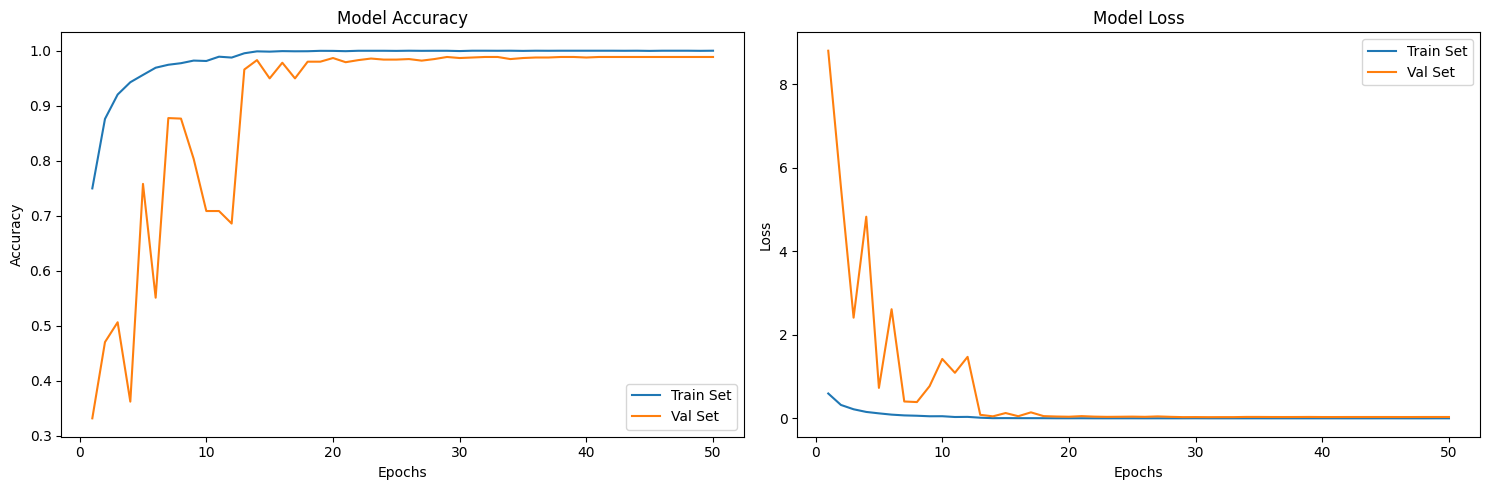

20/20 [==============================] - 0s 19ms/step - loss: 0.0922 - accuracy: 0.9723
Test Accuracy:  97.23
              precision    recall  f1-score   support

      glioma     0.9824    0.9755    0.9789       286
  meningioma     0.9375    0.9507    0.9441       142
   pituitary     0.9839    0.9839    0.9839       186

    accuracy                         0.9723       614
   macro avg     0.9679    0.9700    0.9690       614
weighted avg     0.9725    0.9723    0.9724       614



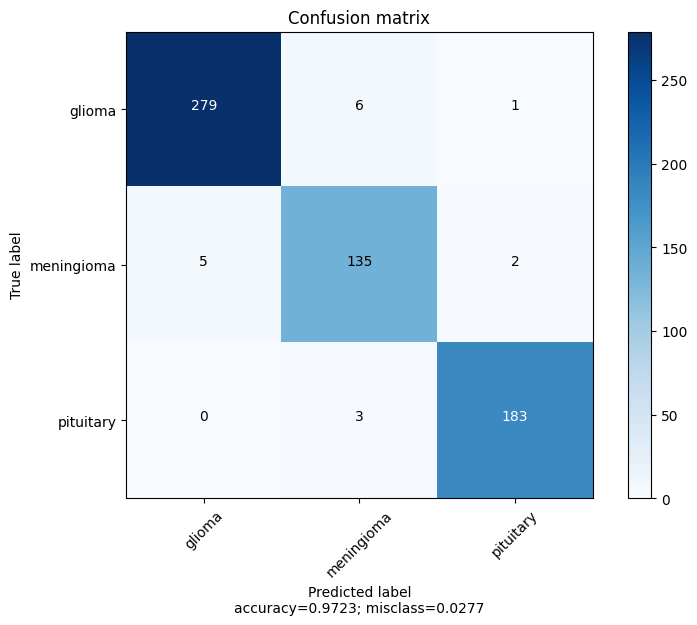

In [10]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f


100%|██████████| 186/186 [00:00<00:00, 192.71it/s]


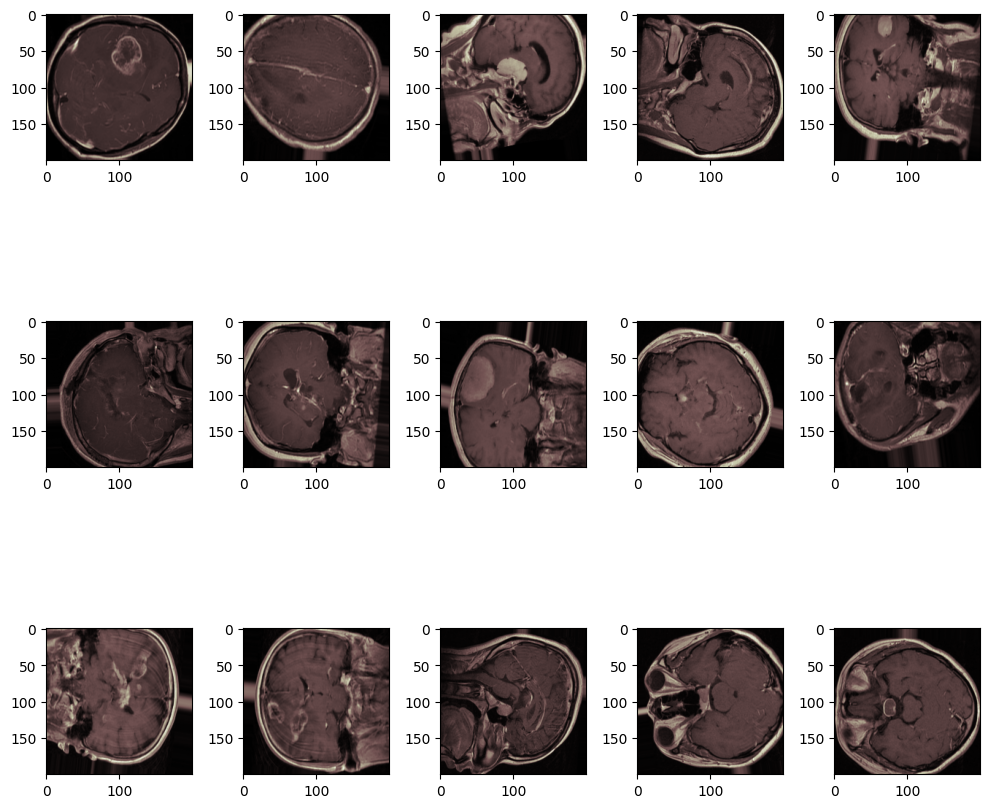

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5807 - accuracy: 0.7552
Epoch 1: saving model to model-DenseNet121.h5
Epoch 1: 24.70 seconds
264/264 [==============================] - 25s 70ms/step - loss: 0.5812 - accuracy: 0.7552 - val_loss: 11.9493 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8730
Epoch 2: saving model to model-DenseNet121.h5
Epoch 2: 16.91 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.3195 - accuracy: 0.8730 - val_loss: 14.9440 - val_accuracy: 0.4089 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9152
Epoch 3: saving model to model-DenseNet121.h5
Epoch 3: 16.89 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.2174 - accuracy: 0.9153 - val_loss: 4.3450 - val_accuracy: 0.5294 - lr: 1.00

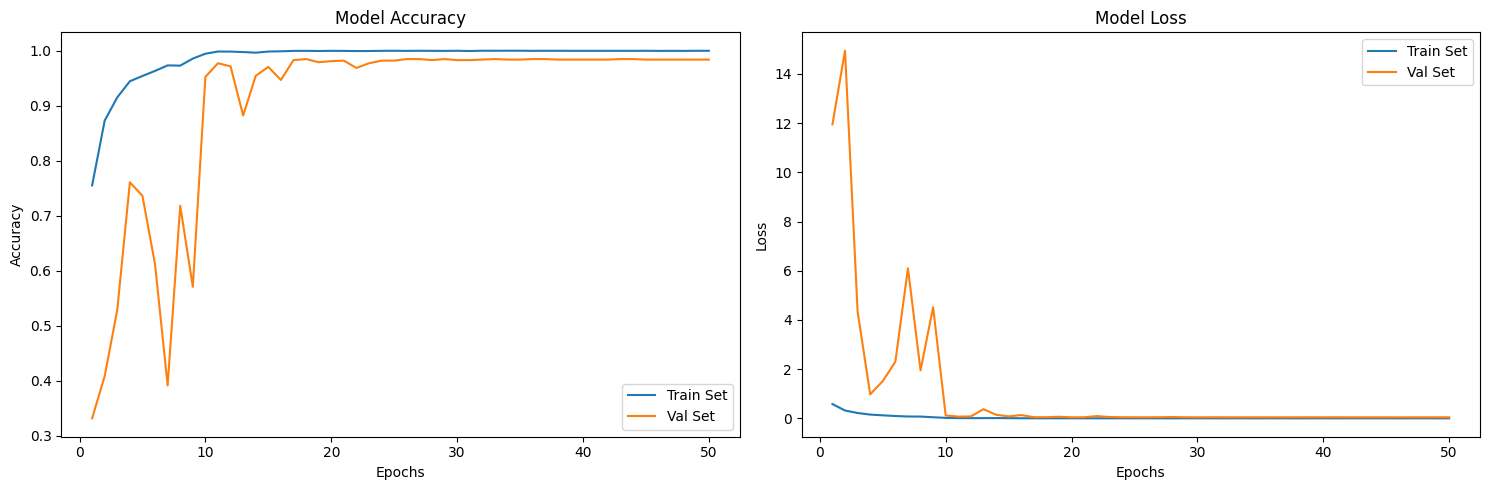

20/20 [==============================] - 0s 19ms/step - loss: 0.1387 - accuracy: 0.9625
Test Accuracy:  96.25
              precision    recall  f1-score   support

      glioma     0.9755    0.9755    0.9755       286
  meningioma     0.9225    0.9225    0.9225       142
   pituitary     0.9731    0.9731    0.9731       186

    accuracy                         0.9625       614
   macro avg     0.9571    0.9571    0.9571       614
weighted avg     0.9625    0.9625    0.9625       614



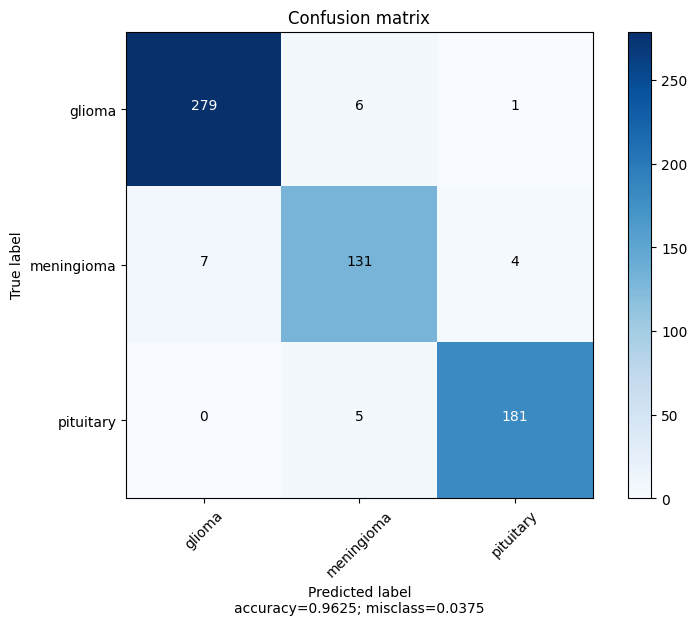

In [12]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.38it/s]


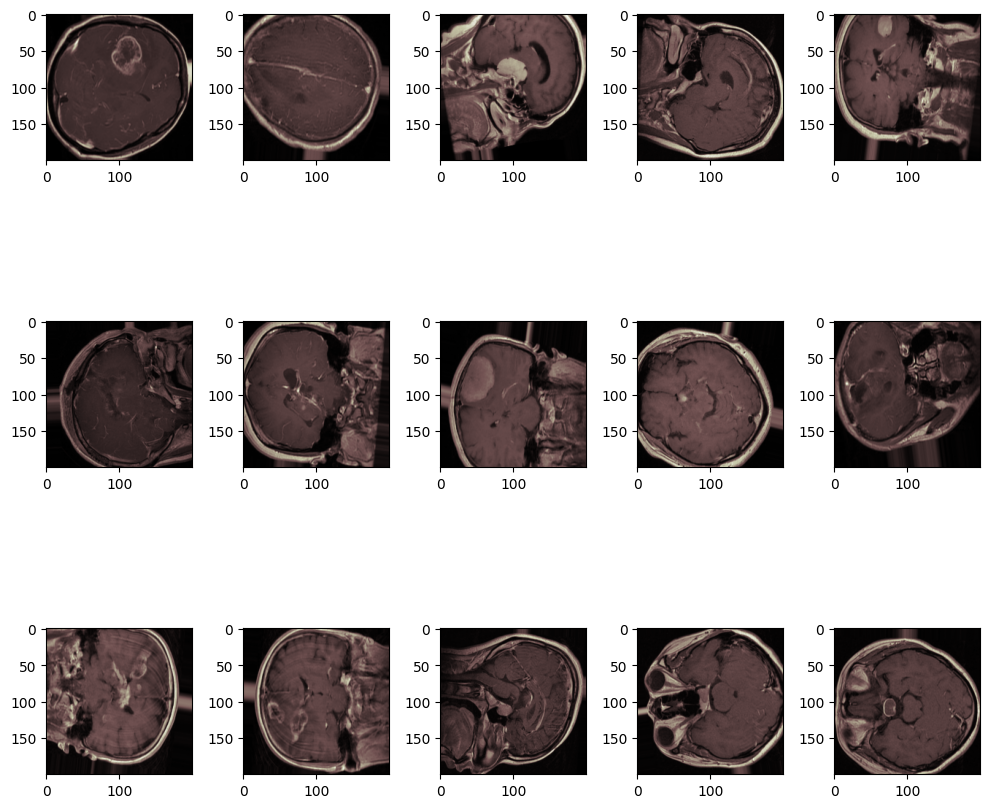

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5835 - accuracy: 0.7538
Epoch 1: saving model to model-DenseNet121.h5
Epoch 1: 24.58 seconds
264/264 [==============================] - 25s 69ms/step - loss: 0.5831 - accuracy: 0.7541 - val_loss: 10.7789 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.8774
Epoch 2: saving model to model-DenseNet121.h5
Epoch 2: 16.79 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.3194 - accuracy: 0.8776 - val_loss: 7.5215 - val_accuracy: 0.4611 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2222 - accuracy: 0.9167
Epoch 3: saving model to model-DenseNet121.h5
Epoch 3: 16.83 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.2229 - accuracy: 0.9165 - val_loss: 10.4894 - val_accuracy: 0.3387 - lr: 1.00

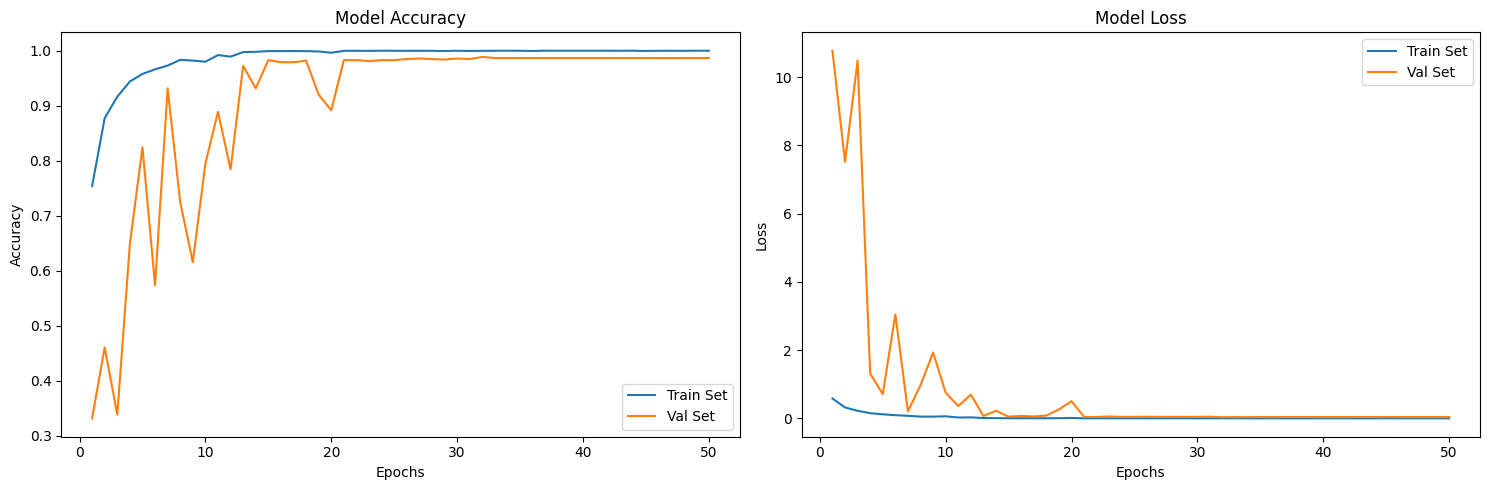

20/20 [==============================] - 0s 19ms/step - loss: 0.0842 - accuracy: 0.9739
Test Accuracy:  97.39
              precision    recall  f1-score   support

      glioma     0.9929    0.9720    0.9823       286
  meningioma     0.9514    0.9648    0.9580       142
   pituitary     0.9632    0.9839    0.9734       186

    accuracy                         0.9739       614
   macro avg     0.9691    0.9736    0.9713       614
weighted avg     0.9743    0.9739    0.9740       614



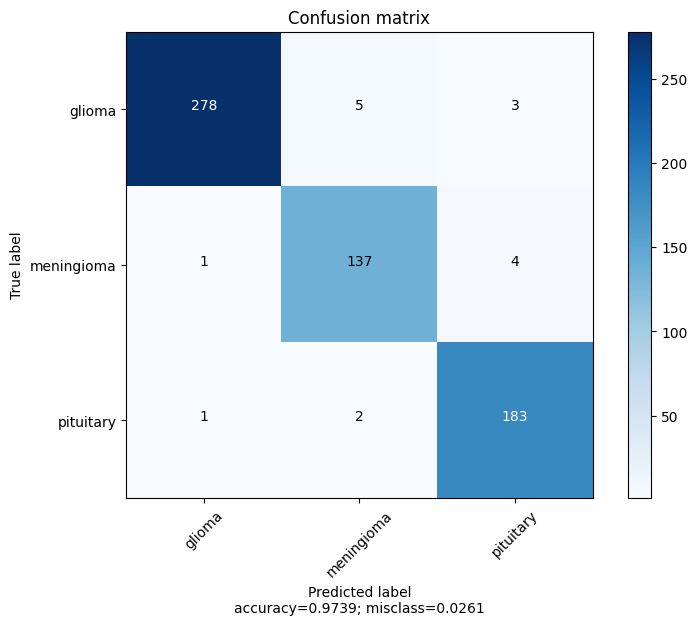

In [14]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.01it/s]


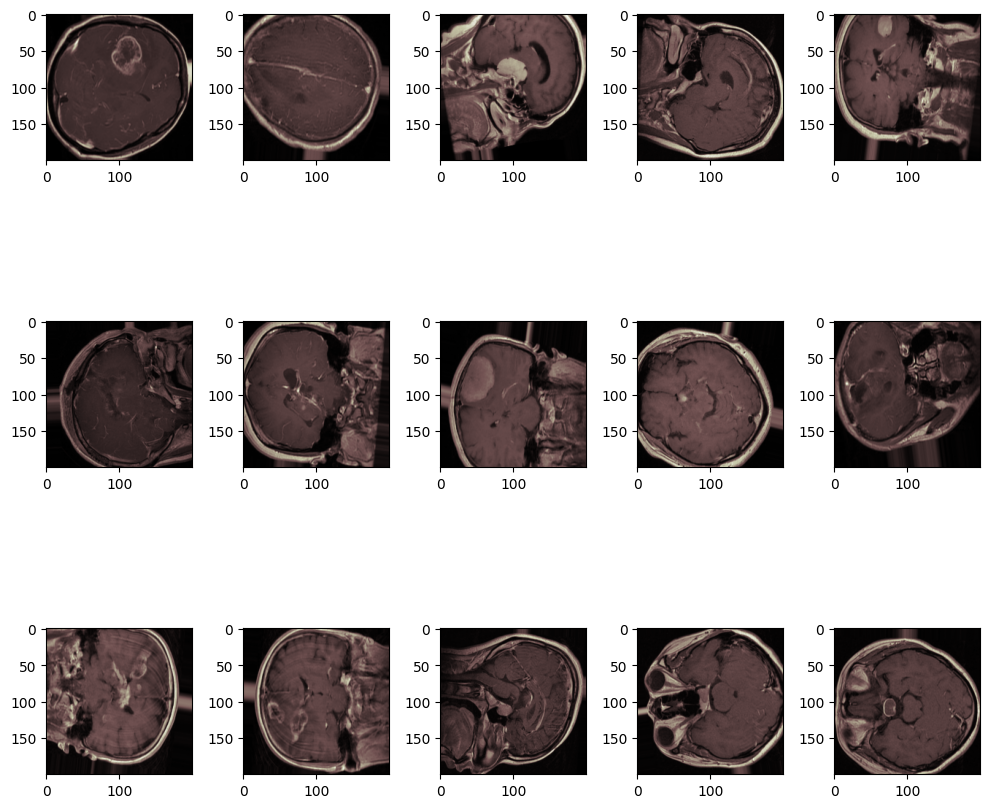

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.6101 - accuracy: 0.7451
Epoch 1: saving model to model-DenseNet121.h5
Epoch 1: 24.82 seconds
264/264 [==============================] - 25s 69ms/step - loss: 0.6094 - accuracy: 0.7455 - val_loss: 3.9874 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.8654
Epoch 2: saving model to model-DenseNet121.h5
Epoch 2: 16.91 seconds
264/264 [==============================] - 17s 64ms/step - loss: 0.3461 - accuracy: 0.8655 - val_loss: 6.6755 - val_accuracy: 0.4004 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9055
Epoch 3: saving model to model-DenseNet121.h5
Epoch 3: 16.58 seconds
264/264 [==============================] - 17s 63ms/step - loss: 0.2372 - accuracy: 0.9056 - val_loss: 0.5341 - val_accuracy: 0.7846 - lr: 1.0000

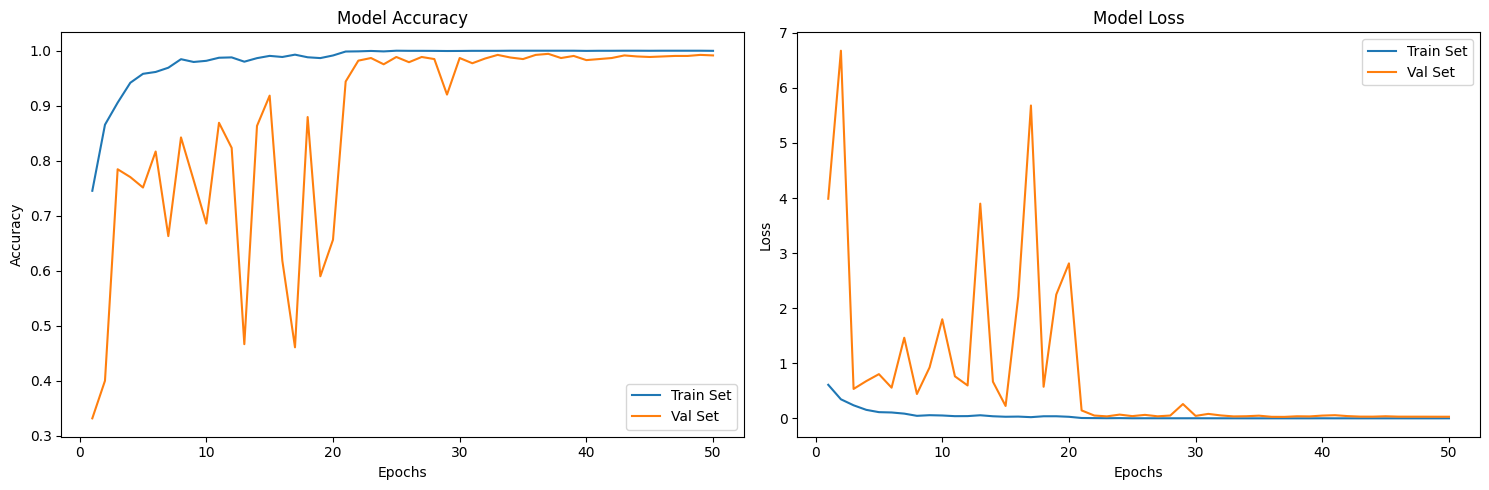

20/20 [==============================] - 0s 18ms/step - loss: 0.1159 - accuracy: 0.9691
Test Accuracy:  96.91
              precision    recall  f1-score   support

      glioma     0.9860    0.9825    0.9842       286
  meningioma     0.9500    0.9366    0.9433       142
   pituitary     0.9577    0.9731    0.9653       186

    accuracy                         0.9691       614
   macro avg     0.9645    0.9641    0.9643       614
weighted avg     0.9691    0.9691    0.9690       614



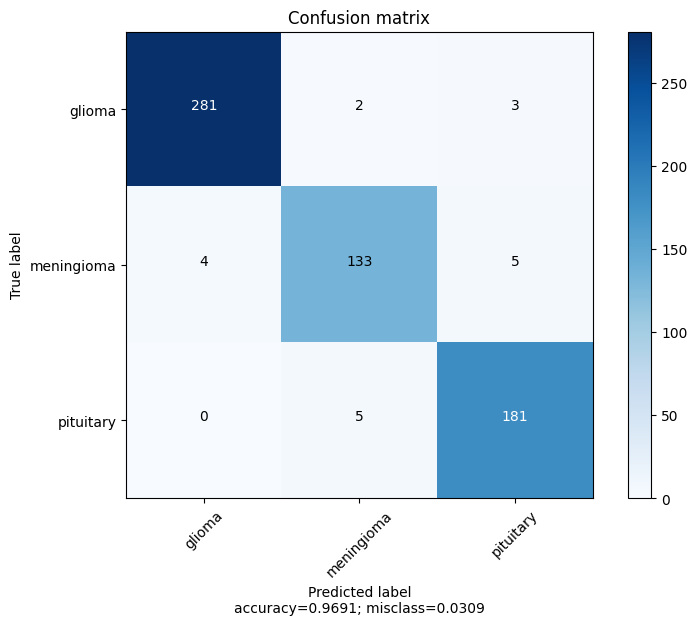

In [16]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)